In [8]:
import sys
import os
import struct
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_plotting_defaults()
from utils import roi_utils, nsd_utils, default_paths, stats_utils

In [32]:
# Load results of the fitting procedure

subject = 1
volume_space=True
feature_type_list_long = ['gabor_solo_ridge_12ori_8sf',\
                 'texture_pyramid_ridge_4ori_4sf_pca_HL','sketch_tokens',\
                 'alexnet_best_layer_pca', 'clip_RN50_best_layer_pca']
feature_type_list = ['gabor',\
                 'texture_pyramid','sketch_tokens',\
                 'alexnet', 'clip']
nf = [0,0,0,0,0,0]
# feature_type_list_long = ['semantic_discrim_raw']
# feature_type_list = ['raw']


for fi, fitting_type in enumerate(feature_type_list_long):
    out= load_fits.load_fit_results(subject, fitting_type,n_from_end=nf[fi],verbose=True);

    if fi==0:
        n_voxels = out['sem_corr_each_axis'].shape[0]
        sem_corr = np.zeros((len(feature_type_list), n_discrim_types, n_voxels))
        sem_discrim = np.zeros((len(feature_type_list), n_discrim_types, n_voxels))
        clip_r2 = np.zeros((n_voxels,))
        
    sem_corr[fi,:,:] = out['sem_corr_each_axis'].T
    sem_discrim[fi,:,:] = out['sem_discrim_each_axis'].T
    
    if 'clip' in fitting_type:
        clip_r2 = out['val_r2'][:,0]
 
    

loading from /user_data/mmhender/imStat/model_fits/S01/gabor_solo_ridge_12ori_8sf/Feb-05-2022_2056_56/all_fit_params.npy

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'saved_prfs_fn', 'best_layer_each_voxel', 'saved_best_layer_fn', 'voxel_subset_is_done_trn', 'voxel_subset_is_done_val', 'corr_each_feature', 'sem_discrim_each_axis', 'sem_corr_each_axis', 'discrim_type_list', 'n_ori_gabor', 'n_sf_gabor', 'gabor_nonlin_fn'])
loading from /user_data/mmhender/imStat/model_fits/S01/texture_pyramid_ridge_4ori_4sf_pca_HL/Feb-05-2022_2057_18/all_fit_params.npy

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape

In [16]:
which_prf_grid=5
labels_fn = os.path.join(default_paths.stim_labels_root,'S%d_within_prf_grid%d'%(subject, which_prf_grid), \
                 'S%d_concat_prf0.csv'%(subject))
df = pd.read_csv(labels_fn, index_col=0)
discrim_type_list = list(df.keys())
n_discrim_types = len(discrim_type_list)

In [11]:
# roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=False,volume_space=True,verbose=False) 
roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=True,volume_space=True,verbose=False) 

skip_inds = [10,11,15,23]
retlabs, facelabs, placelabs, bodylabs, \
        ret_names, face_names, place_names, body_names = roi_def

nret = len(ret_names)
nface = len(face_names)
nplace = len(place_names)
nbody = len(body_names)    
n_rois = len(ret_names) + len(face_names) + len(place_names) + len(body_names)
roi_names = ret_names+face_names+place_names+body_names

is_ret = np.arange(0, n_rois)<nret
is_face = (np.arange(0, n_rois)>=nret) & (np.arange(0, n_rois)<nret+nface)
is_place = (np.arange(0, n_rois)>=nret+nface) & (np.arange(0, n_rois)<nret+nface+nplace)
is_body = np.arange(0, n_rois)>=nret+nface+nplace


In [17]:
areas2plot = np.array([0,1,2,3,6,13,14,17,18,20,21])
print(np.array(roi_names)[areas2plot])
print(np.array(roi_names)[~np.isin(np.arange(len(roi_names)), areas2plot)])
n_rois_plot = len(areas2plot)

['V1' 'V2' 'V3' 'hV4' 'LO1-2' 'FFA-1' 'FFA-2' 'OPA' 'PPA' 'EBA' 'FBA-1']
['VO1-2' 'PHC1-2' 'TO1-2' 'V3ab' 'IPS0-5' 'SPL1' 'FEF' 'OFA' 'mTL-faces'
 'aTL-faces' 'RSC' 'FBA-2' 'mTL-bodies']


In [35]:
np.mean(vox2use)

0.7786503191812747

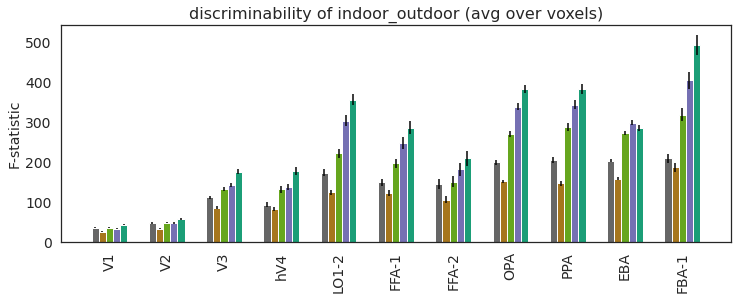

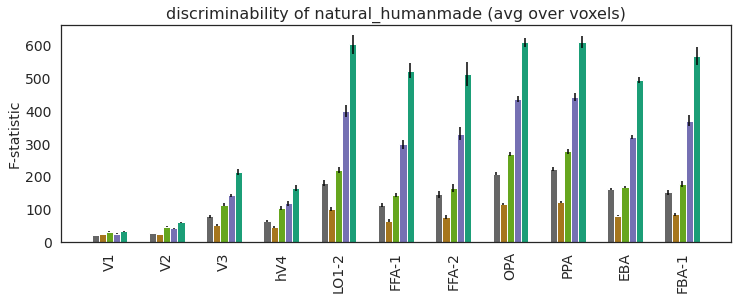

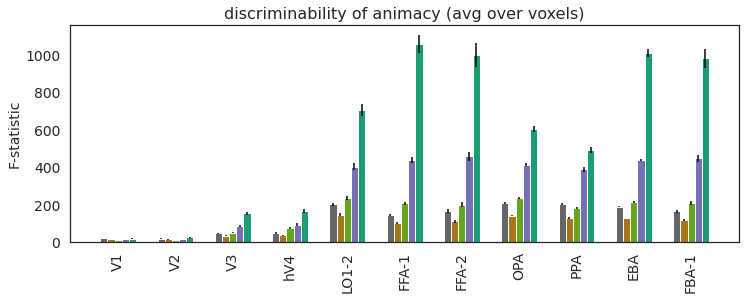

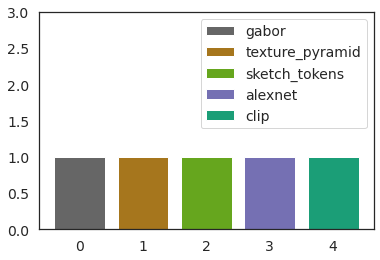

In [34]:

feature_colors = np.flipud(cm.Dark2(np.linspace(0,1,len(feature_type_list))))
bar_jitters = np.linspace(-0.25, 0.25,len(feature_type_list))
bar_width = np.diff(bar_jitters[0:2])[0]
    
dd2plot = [0,1,2]

vox2use = clip_r2>0.01

for dd in dd2plot:
    
    discrim_type = discrim_type_list[dd]
    
    mean_val_each_roi = np.zeros((len(feature_type_list), len(areas2plot)))
    std_val_each_roi = np.zeros((len(feature_type_list), len(areas2plot)))
    n_each_roi = np.zeros((len(areas2plot),))
    
    for fi in range(len(feature_type_list)):
        for ri, rr in enumerate(areas2plot):
            if is_ret[rr]:
                inds_this_roi = retlabs==rr
            elif is_face[rr]:
                inds_this_roi = facelabs==(rr-nret)
            elif is_place[rr]:
                inds_this_roi = placelabs==(rr-nret-nface)
            elif is_body[rr]:
                inds_this_roi = bodylabs==(rr-nret-nface-nplace)

            inds_this_roi = inds_this_roi & vox2use
            
            vals = sem_discrim[fi,dd,inds_this_roi]
            
            if len(vals)==0:
                print('no voxels in %s'%roi_names[rr])
                continue
                
            n_each_roi[ri] = len(vals)
            mean_val_each_roi[fi,ri] = np.mean(vals)
            std_val_each_roi[fi,ri] = np.std(vals)
   
    plt.figure(figsize=(12,4));
    
    for fi in range(len(feature_type_list)):
        plt.bar(np.arange(n_rois_plot)+bar_jitters[fi],mean_val_each_roi[fi,:],\
                width=bar_width, color=feature_colors[fi,:])
        plt.errorbar(np.arange(n_rois_plot)+bar_jitters[fi],mean_val_each_roi[fi,:],\
                     std_val_each_roi[fi,:]/np.sqrt(n_each_roi), ecolor='k', \
                    ls='none',zorder=10)
    plt.xticks(np.arange(n_rois_plot), labels=np.array(roi_names)[areas2plot], rotation=90);
    plt.ylabel('F-statistic')
    plt.title('discriminability of %s (avg over voxels)'%discrim_type)
#     plt.ylim([0,1.2])

plt.figure();
for fi in range(len(feature_type_list)):
    plt.bar([fi],[1],color=feature_colors[fi,:])
plt.ylim([0,3])
plt.legend(feature_type_list)

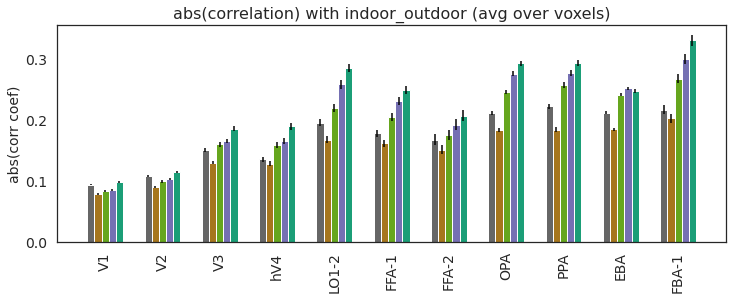

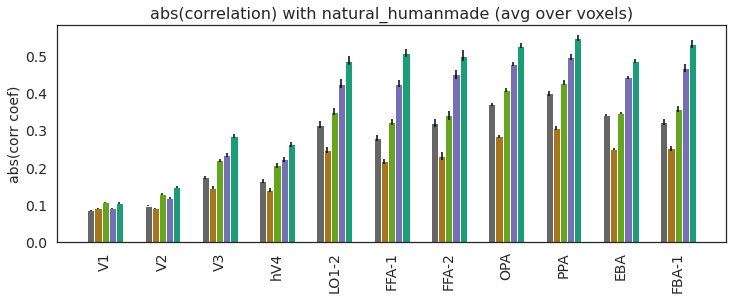

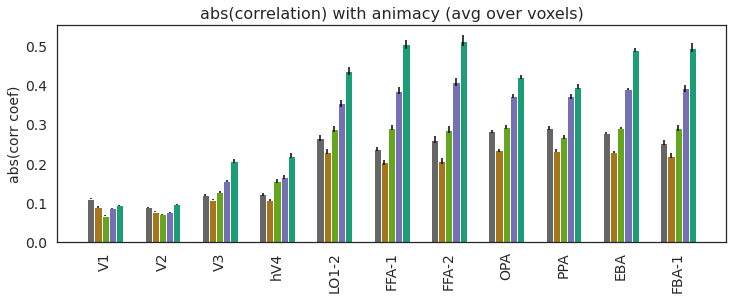

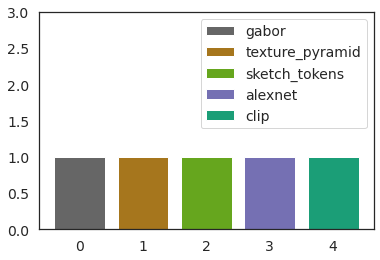

In [36]:

feature_colors = np.flipud(cm.Dark2(np.linspace(0,1,len(feature_type_list))))
bar_jitters = np.linspace(-0.25, 0.25,len(feature_type_list))
bar_width = np.diff(bar_jitters[0:2])[0]
    
dd2plot = [0,1,2]

vox2use = clip_r2>0.01


for dd in dd2plot:
    
    discrim_type = discrim_type_list[dd]
    
    mean_val_each_roi = np.zeros((len(feature_type_list), len(areas2plot)))
    std_val_each_roi = np.zeros((len(feature_type_list), len(areas2plot)))
    n_each_roi = np.zeros((len(areas2plot),))
    
    for fi in range(len(feature_type_list)):
        for ri, rr in enumerate(areas2plot):
            if is_ret[rr]:
                inds_this_roi = retlabs==rr
            elif is_face[rr]:
                inds_this_roi = facelabs==(rr-nret)
            elif is_place[rr]:
                inds_this_roi = placelabs==(rr-nret-nface)
            elif is_body[rr]:
                inds_this_roi = bodylabs==(rr-nret-nface-nplace)

            inds_this_roi = inds_this_roi & vox2use
            
            vals = np.abs(sem_corr[fi,dd,inds_this_roi])
            
            if len(vals)==0:
                print('no voxels in %s'%roi_names[rr])
                continue
                
            n_each_roi[ri] = len(vals)
            mean_val_each_roi[fi,ri] = np.mean(vals)
            std_val_each_roi[fi,ri] = np.std(vals)
   
    plt.figure(figsize=(12,4));
    
    for fi in range(len(feature_type_list)):
        plt.bar(np.arange(n_rois_plot)+bar_jitters[fi],mean_val_each_roi[fi,:],\
                width=bar_width, color=feature_colors[fi,:])
        plt.errorbar(np.arange(n_rois_plot)+bar_jitters[fi],mean_val_each_roi[fi,:],\
                     std_val_each_roi[fi,:]/np.sqrt(n_each_roi), ecolor='k', \
                    ls='none',zorder=10)
    plt.xticks(np.arange(n_rois_plot), labels=np.array(roi_names)[areas2plot], rotation=90);
    plt.ylabel('abs(corr coef)')
    plt.title('abs(correlation) with %s (avg over voxels)'%discrim_type)
#     plt.ylim([0,1.2])

plt.figure();
for fi in range(len(feature_type_list)):
    plt.bar([fi],[1],color=feature_colors[fi,:])
plt.ylim([0,3])
plt.legend(feature_type_list)

In [23]:
bar_jitters

array([-0.25 , -0.125,  0.   ,  0.125,  0.25 ])

In [48]:
mean_discrim_each_roi[:,0,4]

array([0.10729276, 0.3136233 , 0.31563358, 0.35209018, 0.31874821,
              nan])

In [32]:
inds2use.shape

(24,)

In [33]:
mean_discrim_each_roi.shape

(6, 24, 6)

In [7]:
# Make plots in pycortex for variance partitioning analysis

import cortex
import copy
port=53333

out = outlist[3]
# fitting_type = fitting_types[0]

maps = []
names = []
cmaps = []
mins = []
maxes =[]

vox2plot = np.ones((out['discrim_each_axis'].shape[0],))==1
# vox2plot = out['val_r2'][:,0]>0

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out);
print([np.max(best_ecc_deg), np.max(best_size_deg)])
names = ['pRF eccentricity', 'pRF angle', 'pRF size']
maps = [best_ecc_deg, best_angle_deg, best_size_deg]
cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn']
mins = [0,0,0]
maxes = [7, 360, 8.4]


# maps += [np.sqrt(out['val_r2'][:,0])]
# names += ['sketch tokens model R2 (sqrt)']
# cmaps += ['PuBu']
# mins += [0]
# maxes += [0.6]

for fi, fitting_type in enumerate(fitting_types):
    out = outlist[fi]
    discrim_each_axis = copy.deepcopy(out['discrim_each_axis'])
    discrim_type_list = ['indoor_outdoor','animacy','person','food','vehicle','animal']
    n_sem_axes = len(discrim_type_list)
    maps += [discrim_each_axis[:,dd] for dd in range(n_sem_axes)]
    names += ['%s: dprime: %s'%(fitting_type, dd) for dd in discrim_type_list]
    cmaps += ['RdBu' for dd in range(n_sem_axes)]
    mins += [-1.5 for dd in range(n_sem_axes)]
    maxes += [1.5 for dd in range(n_sem_axes)]

plot_utils.plot_maps_pycortex(maps, names, subject, out, roi_def=roi_def, vox2plot=vox2plot, \
                              fitting_type=fitting_types[0], \
                              port=port, cmaps=cmaps, mins=mins, maxes=maxes)

[6.9999995, 8.4]
Data is in 3d volume space
navigate browser to: 127.0.0.1:53333
Started server on port 53333
